In [1]:
import torch
import torch.nn as nn
import torch.autograd
from torch.autograd import Variable
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.utils.data as data

In [2]:
#### cvt2tensor = transforms.ToTensor()
cvt2pil = transforms.ToPILImage()

class Spacenet_Dataset(data.Dataset):
    def __init__(self, annotationsFile,train = True, transform=None, target_transform = None):
        files = open(annotationsFile,'r')
        self.transform=transform
        self.target_transform=target_transform
        items=[]
        #print(lines[0].split('\n'))
        for line in files:
            #print(line)
            imp,_ = line.split('\n')
            ip,out = imp.split(' ')
            out = out[:-4]+'segcls.png'
            item = [ip,out]
            items.append(item)
        self.data = items
        self.inp_img_paths=[]
        self.out_img_paths=[]
        for dat in self.data:
            self.inp_img_paths.append(dat[0])
            self.out_img_paths.append(dat[1])
        #print(len(inp_img_paths))
              
    def getImage(self,path):
        pil_image = Image.open(path)
        pil_image = pil_image.convert('RGB')
        return pil_image

    def __getitem__(self, index):
        cur_in_path = self.inp_img_paths[index]
        cur_out_path = self.out_img_paths[index]
        in_image = self.getImage(cur_in_path)
        out_image = self.getImage(cur_out_path)
        
        if self.transform is not None:
            in_image = self.transform(in_image)
            out_image = self.transform(out_image)
        return in_image, out_image
    
    def __len__(self):
        return len(self.inp_img_paths)

imgTransform = transforms.Compose([transforms.Scale((400, 400)),
                                   transforms.ToTensor()])

trainData = Spacenet_Dataset("/home/shriragk/project/AOI_2_Vegas_Train/annotations_RGB/trainval.txt",
                             transform=imgTransform)
valData = Spacenet_Dataset("/home/shriragk/project/AOI_2_Vegas_Train/annotations_RGB/test.txt",
                           transform=imgTransform)
inp,out = trainData[0]

In [3]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 64, 8, stride = 2)
        self.conv2 = nn.Conv2d(64, 128, 6, stride = 2)
        self.conv3 = nn.Conv2d(128, 256, 7,stride = 3)
        self.conv4 = nn.Conv2d(256, 512, 3,stride = 2, padding =2)
        
        self.deconv1 = nn.ConvTranspose2d(512,256,3,stride=2,padding=1)
        self.deconv2 = nn.ConvTranspose2d(256,128,7,stride=3)
        self.deconv3 = nn.ConvTranspose2d(128,64,6,stride=2)
        self.deconv4 = nn.ConvTranspose2d(64,3,8,stride=2,padding=1)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.relu(self.deconv3(out))
        out = F.relu(self.deconv4(out))
        
        return out

In [7]:
import torchvision.models as models
class StanfordNet(nn.Module):
    def __init__(self):
        super(StanfordNet, self).__init__()
        #Pretrained VGG without classifier 
        #self.model = models.vgg19(pretrained  = True).features
         
        """We wanted to play with the first and last layers of VGG but realized that it won't work 8 
        and 11 band images"""
        """self.List = [self.model[i] for i in range(len(self.model))]
        self.List[0] = nn.Conv2d(8,64, kernel_size = 3, stride= 1, padding = 1)
        self.List[]
        self.model = nn.Sequential(*self.List)""" 
        
        # FCC Convolutional layers network.
    
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3) 
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.conv4 = nn.ConvTranspose2d(32, 32, 3) 
        self.conv5 = nn.Conv2d(32, 16, 3)
        self.conv6 = nn.ConvTranspose2d(16, 16, 3) 
        self.conv7 = nn.ConvTranspose2d(16,1,3)

    def forward(self, x):
        
        m = nn.Dropout2d(p=0.1)
        
        '''Norm_1 = nn.BatchNorm2d(16)
        Norm_2 = nn.BatchNorm2d(32)
        Norm_3 = nn.BatchNorm2d(32) 
        Norm_4 = nn.BatchNorm2d(32)
        Norm_5 = nn.BatchNorm2d(16)
        Norm_6 = nn.BatchNorm2d(16)'''
        
        #out = self.model(x)
        
        out = F.relu(self.conv1(x))
        #out = Norm_1(out)
        
        out = F.relu(self.conv2(out))
        #out = Norm_2(out)
        out = F.max_pool2d(out, 2)
        out = m(out)
        
        out = F.relu(self.conv3(out))
        #out = Norm_3(out)
        
        out = F.relu(self.conv4(out))
        #out = Norm_4(out)
        out = F.max_pool2d(out, 2)
        out = m(out)
        
        out = F.relu(self.conv5(out))
        #out = Norm_5(out)
             
        out = F.relu(self.conv6(out))
        #out = Norm_6(out)
        
        out = self.conv7(out)
        
        return out

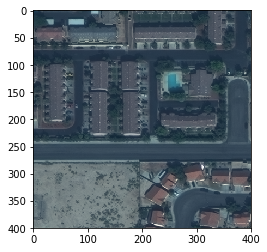

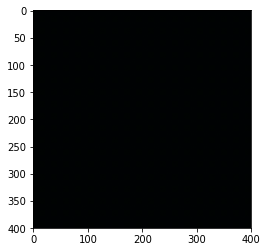

In [4]:
import random

inp,out = trainData[random.randint(0,3672)] # change it to Valdata if necessary, dont forget to change value inside rand()
inp = inp.view(-1,3,400,400)
model = MyNet()
sample_ip = torch.autograd.Variable(inp)
sample_out = model(sample_ip)
sample_out = sample_out.view(-1,400,400)
sample_out = cvt2pil(sample_out.data.cpu())
sample_inp = cvt2pil(inp.view(-1,400,400)) 
plt.imshow(sample_inp)
plt.show()
plt.imshow(sample_out)
plt.show()

In [5]:
imgTransform_train = transforms.Compose([transforms.Scale((650, 650)),
                                   transforms.ToTensor()])
imgTransform_val = transforms.Compose([transforms.Scale((163, 163)),
                                   transforms.ToTensor()])
trainData = Spacenet_Dataset("/home/shriragk/project/AOI_2_Vegas_Train/annotations_RGB/trainval.txt",
                             transform=imgTransform_train)
valData = Spacenet_Dataset("/home/shriragk/project/AOI_2_Vegas_Train/annotations_RGB/test.txt",
                           transform=imgTransform_val)

trainLoader = torch.utils.data.DataLoader(trainData, batch_size = 32, 
                                          shuffle = True, num_workers = 4)
valLoader = torch.utils.data.DataLoader(valData, batch_size = 1, 
                                        shuffle = False, num_workers = 4)

In [8]:
from tqdm import tqdm as tqdm

train_loss=[]
test_loss=[]

def train_rnn_model(model, criterion, optimizer, trainData, valData, n_epochs = 10, use_gpu = False):      
    
    if use_gpu:
        print('using GPU!')
        model = model.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        cum_loss = 0.0
        accuracy = 0
        
        # Make a pass over the training data.
        t = tqdm(trainData, desc = 'Training epoch %d' % epoch)
        model.train()  # This is important to call before training!
        for (i,(ip_image, out_image)) in enumerate(t): 
            #print(ip_image.size())
            #print(out_image.size())
            input_image = torch.autograd.Variable(ip_image)
            target = torch.autograd.Variable(out_image)

            if use_gpu:
                input_image = input_image.cuda()
                target = target.cuda()
                
            y_ = model(input_image)

            loss = criterion(y_, target)
            cum_loss += loss.data[0]

            optimizer.zero_grad()

            loss.backward()
                    # Weight and bias updates.
            optimizer.step()                

            # logging information.
            t.set_postfix(loss = cum_loss / (1 + i)) 

        train_loss.append(cum_loss/(i+1))


        # Make a pass over the validation data.
        cum_loss = 0.0
        accuracy = 0
        
        t = tqdm(valData, desc = 'Validation epoch %d' % epoch)
        model.eval()  # This is important to call before evaluating!
        for (i,(ip_image,out_image)) in enumerate(t): 
        
            input_image = torch.autograd.Variable(ip_image)
            target = torch.autograd.Variable(out_image)

            if use_gpu:
                input_image = input_image.cuda()
                target = target.cuda()
                
            y_ = model(input_image)

            loss = criterion(y_, target)
            cum_loss += loss.data[0]
            
        test_loss.append(cum_loss/(i+1))
    return model

model = StanfordNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)


# Train the previously defined model.
trained_model = train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 2, use_gpu = True)


Training epoch 0:   0%|          | 0/1541 [00:00<?, ?it/s]

using GPU!


RuntimeError: input and target have different number of elements: input[2 x 1 x 163 x 163] has 53138 elements, while target[2 x 3 x 650 x 650] has 2535000 elements at /opt/conda/conda-bld/pytorch_1503966894950/work/torch/lib/THCUNN/generic/MSECriterion.cu:12


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/shriragk/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/shriragk/anaconda2/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/shriragk/anaconda2/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



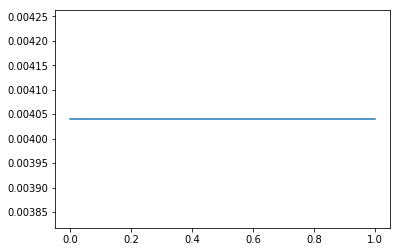

In [10]:
import matplotlib.pyplot as plt

plt.plot(test_loss)
plt.show()


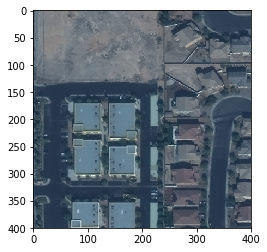

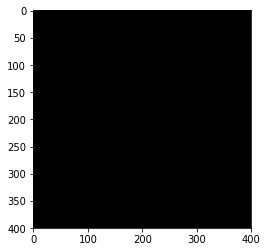

In [8]:
inp,out = trainData[random.randint(0,3672)] # change it to Valdata if necessary, dont forget to change value inside rand()
inp = inp.view(-1,3,400,400)
model = MyNet()
sample_ip = torch.autograd.Variable(inp)
sample_out = trained_model(sample_ip.cuda())
sample_out = sample_out.view(-1,400,400)
sample_out = cvt2pil(sample_out.data.cpu())
sample_inp = cvt2pil(inp.view(-1,400,400)) 
plt.imshow(sample_inp)
plt.show()
plt.imshow(sample_out)
plt.show()

In [90]:
from PIL import Image
import numpy as np
black_thresh = 0.2
nblack = 0
for img in trainData:
    matrix = (img[0][0] + img[0][1] + img[0][2]).div(3.0)
    #print(img[0][0].view(-1).numpy() < )
    stuff = np.sum(matrix.view(-1).numpy() < black_thresh)
    if(float(stuff)/len(matrix.view(-1).numpy()) > 0.5):
        nblack += 1
            
print(nblack)

93


In [43]:
black_thresh = [50]*400*400
print(black_thresh)

[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,

In [64]:
x = np.array([1,2,3,4,4,5,6])
np.sum(x < 3)

2

In [77]:
len(trainData)

3081